# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Homework 5 - Clustering and Reinforcement Learning




**Harvard University**<br/>
**Spring 2019**<br/>
**Instructors**: Mark Glickman and Pavlos Protopapas 


<hr style="height:2pt">

### Homework 5 is due 4/3  (This is individual homework - No collaboration)

In [ ]:
#PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- This is individual homework - No collaboration/Groups
- Problem 1 + Problem 2 = 75 points ; Problem 3 = 25 points
- To install `gym` package - please use `pip install gym`
- To submit your assignment, please follow the instructions on Canvas.
- Please restart the kernel and run the entire notebook again before you submit.

<hr style="height:2pt">

### Please use the libraries below:

In [68]:
import os
# This can make the kernel die if it doesn't go well
os.environ['R_HOME'] = "/usr/share/anaconda3/lib/R"

import pandas as pd
from rpy2.robjects.packages import importr
r_utils = importr('utils')
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
r_ggplot2 = importr('ggplot2')
import IPython
import rpy2
from rpy2.robjects.lib.grdevices import render_to_bytesio
from rpy2.robjects import pandas2ri
pandas2ri.activate()
import rpy2.robjects.lib.ggplot2 as ggplot2
r_stats = importr('stats')
r_factoextra = importr('factoextra')
r_base = importr('base')
import scipy.cluster.hierarchy as hac
from scipy.spatial.distance import pdist
from sklearn.preprocessing import StandardScaler

In [69]:
#RL
import gym
from gym.envs.registration import register
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
import sys
import pylab
import random
import numpy as np
from collections import deque
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import Sequential
#from tqdm import tqdm
from copy import deepcopy
import numpy.linalg as LA

Note that this has been tested on JupyterHub

Note that this has been tested with 
* pandas version 0.23.4
* rpy2 version 2.9.4
* ggplot2 version 2.2.1

The latest libraries may have changed somewhat since these versions; if you are having problems, try using these versions.


<hr style="height:2pt">

<div class="theme">*Handy* Algorithms </div>


    
In this assignment, you will be working with data collected from a motion capture camera system. The system was used to record 14 different users performing 5 distinct hand postures with markers attached to a left-handed glove. A set of markers on the back of the glove was used to establish a local coordinate system for the hand, and 8 additional markers were attached to the thumb and fingers of the glove. A total of 24 features were collected based on observations from the camera system. Two other variables in the dataset were the ID of the user and the posture that the user made.

These data have been preprocessed, including transformation to the local coordinate system of the record, removal of outliers, and removal of missing data.

The dataset `postures_clean.csv` contains 38,943 rows and 26 columns. Each row corresponds to a single frame as captured by the camera system. The data are represented in the following manner:

`Class (type: Integer). The hand posture of the given observation, with`

`1 = Fist (with thumb out)`

`2 = Stop (hand flat)`

`3 = Point1 (point with index finger)`

`4 = Point2 (point with index and middle fingers)`

`5 = Grab (fingers curled as if to grab)`

`User (type: Integer). The ID of the user that contributed the record.`

`X0, Y0, Z0, X1, Y1, Z1,..., X7, Y7, Z7 (type: Real). The x-coordinate, y-coordinate, and z-coordinate of the eight unlabeled marker positions.`



Start by reading the dataset into a pandas data frame.

In [70]:
postures_clean = pd.read_csv('data/postures_clean.csv')

In [71]:
display(postures_clean.head())
display(postures_clean.info())
display(postures_clean.describe())

Class  User         X0         Y0         Z0         X1          Y1  \
0      1     0  72.692270  50.023771 -72.963253 -11.593076   81.234142   
1      1     0  85.648015  73.561022 -71.838316  31.595034   90.217896   
2      1     0 -10.346977  81.751331 -25.587870  33.414886   91.985986   
3      2     0  63.554969  98.490988  11.165920  49.159831  154.330730   
4      2     0  80.873812  93.722537  -4.988816  63.572103   98.476638   

          Z1         X2          Y2    ...             Z4         X5  \
0 -28.450210  51.729995   82.844469    ...     -47.909511  10.028439   
1 -47.246688  52.230858   82.361548    ...     -25.243914  10.277516   
2 -41.364447   5.625100   24.523349    ...     -67.660208  87.019172   
3  32.004168  92.793124  137.143202    ...     -74.307346  58.421362   
4  11.242908  49.142700  154.347050    ...     -71.629823  20.573646   

           Y5         Z5         X6          Y6         Z6         X7  \
0   88.967979 -32.045120   7.732511   25.135415  10.723395  55.943868   
1   88.607958 -32.037539  56.308829   18.774768 -70.996523   6.913199   
2   75.505188 -67.462052  56.807276   20.950953 -68.375831  11.602112   
3   27.499634 -71.713081  12.660462   95.077144  29.664434  84.110115   
4  132.913455  35.349247  92.942044  137.182817   1.297511  35.480104   

           Y7         Z7  
0   19.513363 -70.380124  
1   24.967750   9.697553  
2   89.400536 -29.062279  
3  151.545456  16.891147  
4   99.739019  22.802243  

[5 rows x 26 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38943 entries, 0 to 38942
Data columns (total 26 columns):
Class    38943 non-null int64
User     38943 non-null int64
X0       38943 non-null float64
Y0       38943 non-null float64
Z0       38943 non-null float64
X1       38943 non-null float64
Y1       38943 non-null float64
Z1       38943 non-null float64
X2       38943 non-null float64
Y2       38943 non-null float64
Z2       38943 non-null float64
X3       38943 non-null float64
Y3       38943 non-null float64
Z3       38943 non-null float64
X4       38943 non-null float64
Y4       38943 non-null float64
Z4       38943 non-null float64
X5       38943 non-null float64
Y5       38943 non-null float64
Z5       38943 non-null float64
X6       38943 non-null float64
Y6       38943 non-null float64
Z6       38943 non-null float64
X7       38943 non-null float64
Y7       38943 non-null float64
Z7       38943 non-null float64
dtypes: float64(24), int64(2)
memory usage: 7.7 MB


None

Class          User            X0            Y0            Z0  \
count  38943.000000  38943.000000  38943.000000  38943.000000  38943.000000   
mean       3.533986      8.149501     51.392252     93.748418    -18.956761   
std        1.332452      4.587195     34.070402     40.145995     34.976568   
min        1.000000      0.000000   -108.552738    -67.157904   -120.284665   
25%        2.000000      5.000000     28.169252     74.946345    -43.598807   
50%        4.000000      9.000000     54.596564     93.966079    -15.041397   
75%        5.000000     12.000000     77.390834    130.932659      7.998678   
max        5.000000     14.000000    160.850926    169.175464    113.345119   

                 X1            Y1            Z1            X2            Y2  \
count  38943.000000  38943.000000  38943.000000  38943.000000  38943.000000   
mean      48.644293     97.228337    -16.921813     46.432265     97.351512   
std       34.922596     38.076977     34.671422     36.395332     37.470755   
min     -111.685241    -65.758453   -120.290858    -99.917453    -64.830342   
25%       22.574182     79.747406    -41.210343     17.617698     81.302159   
50%       52.960933     96.690641    -12.046916     51.184849     97.222693   
75%       75.560564    131.729311      9.065824     74.435194    130.794462   
max      158.783454    170.209350    104.697852    163.547310    168.186466   

           ...                 Z4            X5            Y5            Z5  \
count      ...       38943.000000  38943.000000  38943.000000  38943.000000   
mean       ...         -18.446645     45.392642     93.295433    -19.125065   
std        ...          35.597032     37.104094     39.746619     35.602273   
min        ...        -157.199089    -99.014815    -64.282645   -118.328399   
25%        ...         -45.169035     15.849890     76.376404    -46.363837   
50%        ...         -14.823751     50.160084     97.040377    -16.010237   
75%        ...           9.382799     73.761617    126.844621      9.031498   
max        ...         119.237203    180.563322    167.926171    110.898899   

                 X6            Y6            Z6            X7            Y7  \
count  38943.000000  38943.000000  38943.000000  38943.000000  38943.000000   
mean      45.201114     90.839851    -19.920157     44.463433     88.463343   
std       37.556616     40.227409     34.827888     38.378395     40.503378   
min     -100.084275    -67.283707   -153.449813   -108.605639    -64.972157   
25%       15.132050     68.915784    -46.547792     13.081363     63.541846   
50%       49.968499     95.562441    -17.101080     49.601058     93.796334   
75%       74.558859    123.069653      7.767866     75.721811    119.188963   
max      176.409004    168.598384    117.914907    189.221529    169.127359   

                 Z7  
count  38943.000000  
mean     -20.368719  
std       33.943957  
min     -113.733105  
25%      -45.676522  
50%      -19.428819  
75%        6.591351  
max      117.815967  

[8 rows x 26 columns]

In [72]:
ddd = postures_clean.describe()
print(ddd.loc['max'][2:].max() - ddd.loc['max'][2:].min())
print(ddd.loc['min'][2:].max() - ddd.loc['min'][2:].min())

84.630650249566
92.9164434331005


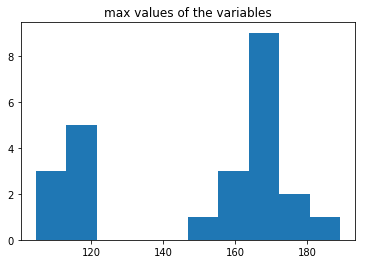

In [73]:
plt.hist(ddd.loc['max'][2:])
plt.title('max values of the variables');

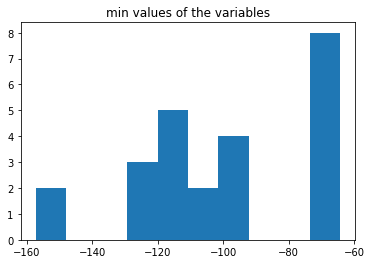

In [74]:
plt.hist(ddd.loc['min'][2:])
plt.title('min values of the variables');

In [75]:
xc = 2 # starting x coordinate variable
yc = 3 # starting y coord
zc = 4 # starting z
end = 26 # final coordiate variable
by = 3 # modulo

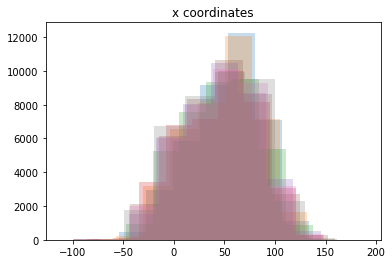

In [57]:
for i in list(range(xc,end,by)):
    plt.hist(postures_clean.iloc[:,i], alpha=0.25)
plt.title('x coordinates');

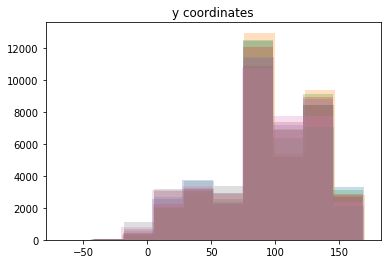

In [58]:
for i in list(range(yc,end,by)):
    plt.hist(postures_clean.iloc[:,i], alpha=0.25)
plt.title('y coordinates');

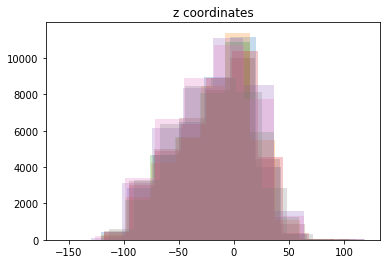

In [59]:
for i in list(range(zc,end,by)):
    plt.hist(postures_clean.iloc[:,i], alpha=0.25)
plt.title('z coordinates');

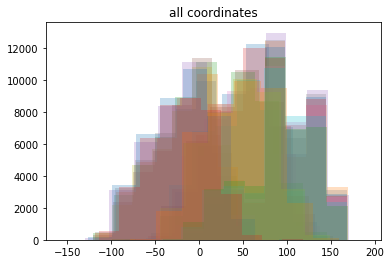

In [61]:
for i in range(2,26):
    plt.hist(postures_clean.iloc[:,i], alpha=0.25)
plt.title('all coordinates');

<div class='exercise'>Problem 1: Clustering with k-means </div>

(a) After appropriate pre-processing run the k-means clustering algorithm, using the function `r_stats.kmeans`, with the number of clusters corresponding to the number of users, `n_start` of 46, and 109 as the random seed. Add the result as a new column called `Cluster14` to your data frame.

<div class="alert alert-block alert-info"> We see from above that the variables all appear to be on roughly the same scale. The ranges of the maximum and minimum values of all the variables (all the coordinates) is not large; the histogram of the maximum and minimum values of the variables does not pose significant concern; and the histogram of the x,y and z-coordinate values are all roughly the same, respectively. Further, we see roughly equal variation among all the variables.

<br/> <br/> 

When looking to preprocess our data for KMeans, we need to wary of variables which might affect algorithm e.g. variables significant orders of magnitude larger than the other variables. Here, however, we do not see a variable that appears to dominate the others. Further, we do not see any clear need to further process our data to make it suitable for KMeans. Thus, we choose not to make any modifications to the data as is not clearly evident that we need to do so, especially since we are dealing with location data which has inherent meaning in its values when comparing it to the other various coordinates and since it is not readily apparent how one might even go about scaling to preserve this meaning. </div>

In [76]:
# load extension for making entire cell R
%load_ext rpy2.ipython

In [77]:
# grab our data
X = postures_clean.iloc[:,2:].copy()

In [78]:
display(X.head())

X0         Y0         Z0         X1          Y1         Z1  \
0  72.692270  50.023771 -72.963253 -11.593076   81.234142 -28.450210   
1  85.648015  73.561022 -71.838316  31.595034   90.217896 -47.246688   
2 -10.346977  81.751331 -25.587870  33.414886   91.985986 -41.364447   
3  63.554969  98.490988  11.165920  49.159831  154.330730  32.004168   
4  80.873812  93.722537  -4.988816  63.572103   98.476638  11.242908   

          X2          Y2         Z2         X3    ...             Z4  \
0  51.729995   82.844469 -55.674024  86.175444    ...     -47.909511   
1  52.230858   82.361548 -55.975665  74.817984    ...     -25.243914   
2   5.625100   24.523349   8.120352  52.961965    ...     -67.660208   
3  92.793124  137.143202   1.064904  80.854870    ...     -74.307346   
4  49.142700  154.347050  32.076937  95.211973    ...     -71.629823   

          X5          Y5         Z5         X6          Y6         Z6  \
0  10.028439   88.967979 -32.045120   7.732511   25.135415  10.723395   
1  10.277516   88.607958 -32.037539  56.308829   18.774768 -70.996523   
2  87.019172   75.505188 -67.462052  56.807276   20.950953 -68.375831   
3  58.421362   27.499634 -71.713081  12.660462   95.077144  29.664434   
4  20.573646  132.913455  35.349247  92.942044  137.182817   1.297511   

          X7          Y7         Z7  
0  55.943868   19.513363 -70.380124  
1   6.913199   24.967750   9.697553  
2  11.602112   89.400536 -29.062279  
3  84.110115  151.545456  16.891147  
4  35.480104   99.739019  22.802243  

[5 rows x 24 columns]

In [79]:
# should be 14 users as stated but lets check
n_users = len(set(postures_clean.User.values))
print(n_users)

14


In [67]:
# set seed and run kmeans
r_base.set_seed(109)
r_km_out = r_stats.kmeans(X, centers=n_users, nstart=46)

In [68]:
%%R -i r_km_out
names(r_km_out) # look at what was returned 

[1] "cluster"      "centers"      "totss"        "withinss"     "tot.withinss"
[6] "betweenss"    "size"         "iter"         "ifault"      


In [69]:
# look at cluster data
print(r_km_out.rx2('cluster')[:15])

 [1]  7  7 14 11  9  2 13  2  8  8  8  9  8 13 12



In [70]:
# add column 
postures_clean['Cluster14'] = r_km_out.rx2('cluster')

In [71]:
# save some data so we dont have to rerun
np.save('cluster14', np.array(r_km_out.rx2('cluster')))
np.save('centers14', np.array(r_km_out.rx2('centers')))

(b) Now visualize the results for k-means on a random sample of 2,000 observations without replacement (setting 109 as the random seed when sampling), using the function `r_factoextra.fviz_cluster`. Does 14 clusters seem to make sense?

In [80]:
# covert pandas df to r df
r_X = pandas2ri.py2ri(X)

In [73]:
%%R
library(factoextra) # load library

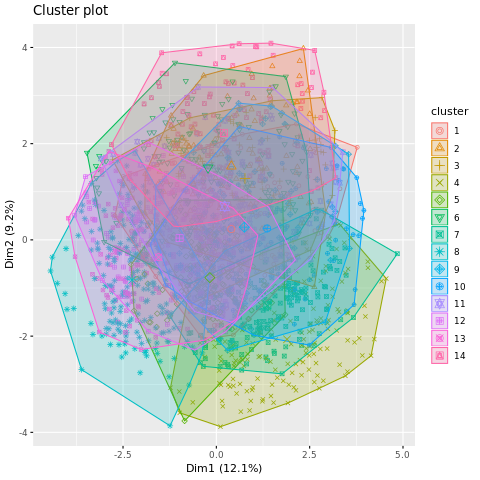

In [75]:
%%R -i r_km_out -i r_X

# set seed
set.seed(109)

# grab samples
n_samps = 2000
samps = sample(1:dim(r_X)[1], n_samps, replace=FALSE)

# visualize
fviz_cluster(object=list(data=r_X[samps,], cluster=r_km_out$cluster[samps]), r_X, geom = "point")

<div class="alert alert-block alert-info">
It is difficult to ascertain the effectiveness of the clustering in the two dimensions plotted as the data is very high dimensional; however, there does not appear to be a clear separation of the clusters and there appears to be a clear “mess” in the center of the plot, indicating 14 clusters does not fit well with the data. Furhter, we would imagine that the data would be best clustered by the class type/ hand posture rather than the user. It is true that perhaps users have slighlty different hand postures for the classes, but the more distinguishable characteristic would be the position itself rather than the suer. 
</div>

(c) Compare the results from your clustering algorithm to the actual users for the entire dataset. To do this :

(i) calculate the Gini coefficient for each cluster, and also report the average Gini coefficient for the clustering method. For $K$ total labels, the Gini coefficient for each cluster is given by $$1 - \sum_{i=1}^K p_i^2,$$ where $p_i$ is the proportion of data point with label $i$ in the cluster (given that there are also $K$ clusters, e.g., 14 people and 14 clusters). 

(ii) calculate the entropy of each cluster, where entropy is defined as $$-\sum_{i=1}^K p_i \log p_i,$$ and also report the average entropy.

Hint: be careful, because r_stats.kmeans returns cluster numbers beginning with 1.

In [76]:
# labels 
labels = postures_clean.User.values

In [77]:
# calculate gini
clusters = np.array(r_km_out.rx2('cluster'))
gini_14 = {}
for clust in set(clusters):
    msk1 = clusters == clust
    gini_clust = []
    for lbl in set(labels):
        msk2 = postures_clean.User == lbl
        msk = msk1 & msk2
        prop = np.sum(msk)/np.sum(msk1)
        temp = np.power(prop,2)
        gini_clust.append(temp)
    gini_14[clust] = 1-sum(gini_clust)
for key, value in gini_14.items():
    print('Cluster {}: Gini = {:.4f}'.format(key, value))
print()
print('Average Gini Value: {}'.format(np.mean((list(gini_14.values())))))

Cluster 1: Gini = 0.9003
Cluster 2: Gini = 0.8963
Cluster 3: Gini = 0.9015
Cluster 4: Gini = 0.8067
Cluster 5: Gini = 0.8373
Cluster 6: Gini = 0.8806
Cluster 7: Gini = 0.8462
Cluster 8: Gini = 0.8344
Cluster 9: Gini = 0.8949
Cluster 10: Gini = 0.8938
Cluster 11: Gini = 0.8971
Cluster 12: Gini = 0.8911
Cluster 13: Gini = 0.8924
Cluster 14: Gini = 0.8986

Average Gini Value: 0.8765199672512927


In [79]:
# calculate entropy
clusters = np.array(r_km_out.rx2('cluster'))
entropy_14 = {}
for clust in set(clusters):
    msk1 = clusters == clust
    entropy_clust = []
    for lbl in set(labels):
        msk2 = postures_clean.User == lbl
        msk = msk1 & msk2
        prop = np.sum(msk)/np.sum(msk1) + 1e-20 # adjustment for log(0); think of as prior
        if prop == 0:
            print(clust, lbl)
        entropy_clust.append(prop*np.log(prop))
    entropy_14[clust] = -sum(entropy_clust)
for key, value in entropy_14.items():
    print('Cluster {}: entropy = {}'.format(key, value))

print()
print('Average Entropy Value: {}'.format(np.mean((list(entropy_14.values())))))

Cluster 1: entropy = 2.4033124449157857
Cluster 2: entropy = 2.3724354356072372
Cluster 3: entropy = 2.4254787580542776
Cluster 4: entropy = 1.9702141653656402
Cluster 5: entropy = 2.0078164396417875
Cluster 6: entropy = 2.2949865071064823
Cluster 7: entropy = 2.06765767266802
Cluster 8: entropy = 1.9910051422025516
Cluster 9: entropy = 2.387604748130628
Cluster 10: entropy = 2.3750447188488892
Cluster 11: entropy = 2.3830886709375294
Cluster 12: entropy = 2.321611803553055
Cluster 13: entropy = 2.3336009980479737
Cluster 14: entropy = 2.402852390143148

Average Entropy Value: 2.2669078496587862


(d) Repeat all of the above steps, but group by posture rather than by user. That is : 

(i) Run the k-means algorithm with 5 centroids instead of 14, creating a variable named `Cluster5` and adding it to the dataset. 

(ii) Visualize the results for k-means on a random sample of 2,000 observations without replacement (setting 109 as the random seed when sampling), using the function `r_factoextra.fviz_cluster`. Does 5 clusters seem to make sense?

(iii) Calculate the Gini coefficient for each cluster, and also report the average Gini coefficient.

(iv) Calculate the entropy of each cluster, and also report the average entropy. 


In [80]:
# set seed and run kmeans
r_base.set_seed(109)
r_km_out_5 = r_stats.kmeans(X, centers=5, nstart=46)

In [81]:
# add column 
postures_clean['Cluster5'] = r_km_out_5.rx2('cluster')

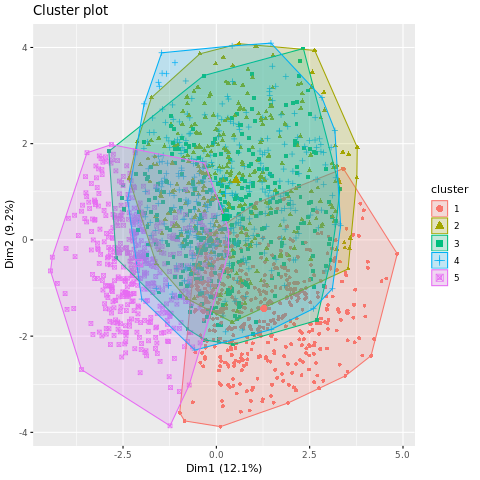

In [82]:
%%R -i r_km_out_5 -i r_X

# set seed
set.seed(109)

# grab samples
n_samps = 2000
samps = sample(1:dim(r_X)[1], n_samps, replace=FALSE)

# visualize
fviz_cluster(object=list(data=r_X[samps,], cluster=r_km_out_5$cluster[samps]), r_X, geom = "point")

In [91]:
# labels 
labels = postures_clean.Class.values

In [95]:
# calculate gini
clusters = np.array(r_km_out_5.rx2('cluster'))
gini_5 = {}
for clust in set(clusters):
    msk1 = clusters == clust
    gini_clust = []
    for lbl in set(labels):
        msk2 = postures_clean.Class == lbl
        msk = msk1 & msk2
        prop = np.sum(msk)/np.sum(msk1)
        if prop == 0:
            print(clust, lbl)
            
        temp = np.power(prop,2)
        gini_clust.append(temp)
    gini_5[clust] = 1-sum(gini_clust)
for key, value in gini_5.items():
    print('Cluster {}: Gini = {:.4f}'.format(key, value))
print()
print('Average Gini Value: {}'.format(np.mean((list(gini_5.values())))))

Cluster 1: Gini = 0.4057
Cluster 2: Gini = 0.7378
Cluster 3: Gini = 0.7271
Cluster 4: Gini = 0.7338
Cluster 5: Gini = 0.2855

Average Gini Value: 0.5779914996159439


In [96]:
# calculate entropy
clusters = np.array(r_km_out_5.rx2('cluster'))
entropy_5 = {}
for clust in set(clusters):
    msk1 = clusters == clust
    entropy_clust = []
    for lbl in set(labels):
        msk2 = postures_clean.Class == lbl
        msk = msk1 & msk2
        prop = np.sum(msk)/np.sum(msk1) +1e-20
        if prop == 0:
            print(clust, lbl)
        entropy_clust.append(prop*np.log(prop))
    entropy_5[clust] = -sum(entropy_clust)
for key, value in entropy_5.items():
    print('Cluster {}: entropy = {}'.format(key, value))

print()
print('Average Entropy Value: {}'.format(np.mean((list(entropy_5.values())))))

Cluster 1: entropy = 0.800725230572676
Cluster 2: entropy = 1.3648838798549976
Cluster 3: entropy = 1.3395074239822171
Cluster 4: entropy = 1.3542699224549317
Cluster 5: entropy = 0.5645252870316899

Average Entropy Value: 1.0847823487793025


(e) What do the results suggest? Does this make sense in the context of what we know about the problem?

In [243]:
print(1-(np.power(.9,2) + np.power(.05,2) + np.power(.05,2)))

0.18500000000000005


In [244]:
print(1-(np.power(.6,2) + np.power(.2,2) + np.power(.2,2)))

0.5599999999999999


<div class="alert alert-block alert-info">
The results suggest that 5 clusters is better than 14. Both the Gini index and entropy value measure the purity of the clusters in the KMenas algorithm for the different number of clusters. When we cluster with 5 clusters, we reach a better purity measure indicating that 5 clusters is in fact what we are clustering to in our data i.e. if 5 clusters (the 'class' variable or number of gestures) is the right thing to cluster by, then the Gini and entropy should be small.
</div>

<div class='exercise'> <b> Problem 2: Clustering Evaluation and Hierarchical Clustering </b> </div>

In the previous problem, we examined the results of running k-means with 5 and 14 centroids on the postures data. In this problem, we will investigate various ways of evaluating the quality of a clustering assignment. For all of these questions, you can work with the sample of 2,000 data points obtained in the previous problem.

Hint: Use the function `r_factoextra.fviz_nbclust`.

(a) Use the elbow method to evaluate the best choice of the number of clusters, plotting the total within-cluster variation against the number of clusters, for k-means clustering with $k \in \{1,2,...,15\}.$
 

/usr/share/anaconda3/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


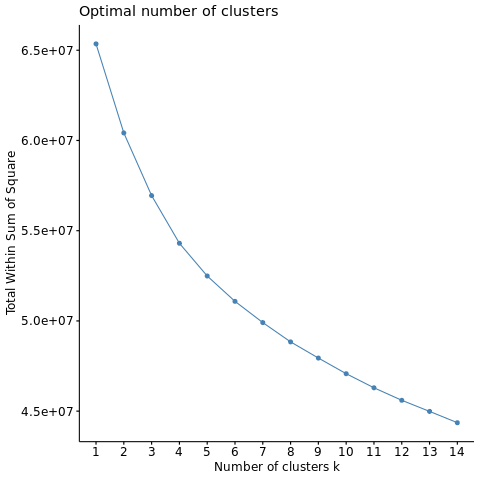

In [99]:
%%R -i r_X

# set seed
set.seed(109)

# grab samples
n_samps = 2000
samps = sample(1:dim(r_X)[1], n_samps, replace=FALSE)

# wss
fviz_nbclust(r_X[samps,], kmeans, method="wss", nstart = 49, k.max=14)

<div class="alert alert-block alert-info">
The above elbow plot is not the best (i.e. not the clearest), but we can still ascertain that a cluster size of 4 or 5 appear to be the most ideal. We determine this as there appears to be a noticeable change in slope on the plot from a cluster of 4 to a cluster of 5 and further from a cluster of 5 to a cluster of 6. Additionally, from a heuristic, it appears that a cluster size of 4 and 5 appear to have the furthest perpendicular distance to the line connecting the KMeans objective value at a cluster of 1 and a cluster of 14. </div>

(b) Use the average silhouette to evaluate the choice of the number of clusters for k-means clustering with $k \in \{1,2,...,15\}$. Plot the results. 

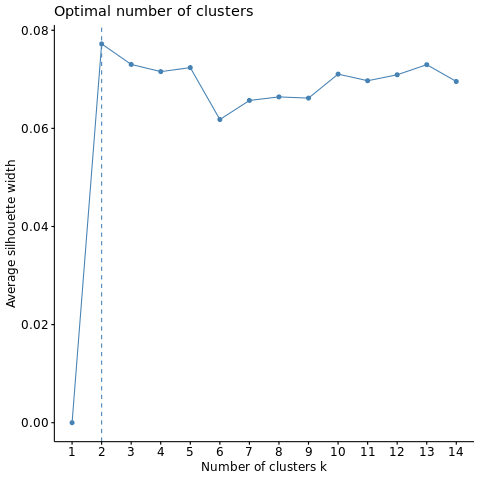

In [100]:
%%R -i r_X

# set seed
set.seed(109)

# grab samples
n_samps = 2000
samps = sample(1:dim(r_X)[1], n_samps, replace=FALSE)

# wss
fviz_nbclust(r_X[samps,], kmeans, method="silhouette", nstart = 49, k.max=14)

<div class="alert alert-block alert-info">
From the above plot, we see that a cluster size of 2 appears to be best. A cluster size of 2 has the highest average silhouette width, indicating for the most part that the data points are where the belong when clustered into 2 groups.</div>

(c) Use the gap statistic to evaluate the choice of the number of clusters for k-means clustering with $k \in \{1,2,..,15\}$. Plot the results. 

Clustering k = 1,2,..., K.max (= 14): .. done
Bootstrapping, b = 1,2,..., B (= 100)  [one "." per sample]:
.................................................. 50 
.................................................. 100 


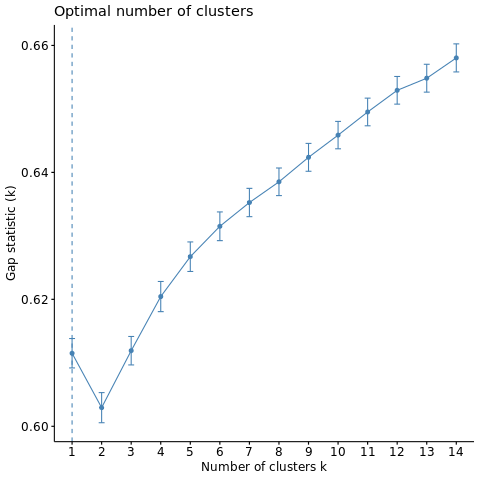

In [101]:
%%R -i r_X

# set seed
set.seed(109)

# grab samples
n_samps = 2000
samps = sample(1:dim(r_X)[1], n_samps, replace=FALSE)

# wss
fviz_nbclust(r_X[samps,], kmeans, method="gap", nstart = 49, k.max=14)

your response here

(d) After analyzing the plots produced by all three of these measures, discuss the number of clusters that you think is the best fit for this dataset. Defend your answer with evidence from the previous parts of this question, the three graphs produced here, and what you surmise about this dataset.

<div class="alert alert-block alert-info">
From the above plot, we see that a cluster size of 1 appears to be best. A cluster of 1 has the highest gap statistic before which we see a non-significant increase in the gap statistic in the next incremental cluster (in fact, from above, we actually see a decrease in the gap statistic incrementally). This is in part suspicious. Perhaps this could be a result of only clustering the random sample of 2000 data points; it may be unlikely, but ideally I would run it for a much larger sample size and just let the algorithm run. That being said, it may also not be suspicious at all. The data is high dimensional and appears to be difficult to find an ideal cluster size, as shown in the largely inconsistent number of clusters determined from the various methods above. 
</div>

_________________________

<div class="alert alert-block alert-info">
From the above plots, it appears that this dataset is not readily and easily cluster-able. We obtain several determinations for the 'optimal' number of clusters from the various methods. I would be tempted to conclude the ideal number of clusters is 5 and defend that result from the elbow plot; however, I know that temptation is a result of knowing that data comes from people making 5 gestures, and I would not know this apriori. Some datasets are just simply difficult to cluster, and it appears like this data is just such an example. The data is very high dimensional which makes clustering difficult and that data seem to overlap significant when reduced to lower dimensions. In conclusion, without knowing the number of classes or users, I would be unsure how to cluster the data. If given a choice between 5 and 14, however, I would still go with 5 clusters even without the class and user labels as 5 clusters is still a better fit than 14 clusters. 
</div>

(e) Hierarchical clustering. Run agglomerative clustering (using Ward's method), and plot the result using a dendrogram. Interpret the results.

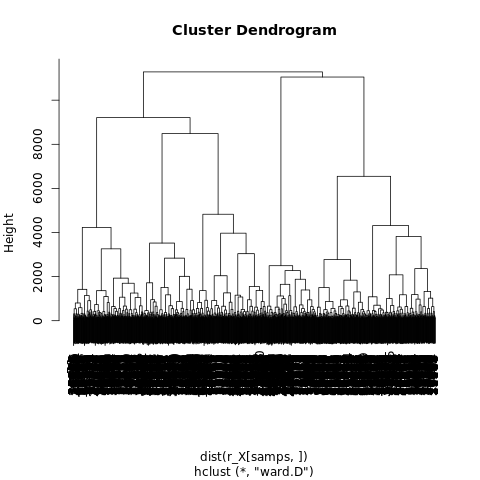

In [16]:
%%R -i r_X
# set seed
set.seed(109)

# grab samples
n_samps = 2000
samps = sample(1:dim(r_X)[1], n_samps, replace=FALSE)

stacked_cluster = hclust(dist(r_X[samps,]), method = "ward.D")
plot(stacked_cluster)

<div class="alert alert-block alert-info">
From the above plot, there appears to be significant increases in the ward distance when the number of clusters decreases from 6 to 5, from 5 to 4, and from 3 to 4. We take notice, however that after we increase the number of clusters from 6 that the decreases in the ward distance all appear to be particularly small relative to the previous drops described as significant. Thus, from the dendrogram, we may conclude that the optimal number of cluster is 6.</div>

<div class='exercise'> <b> Problem 3: Model-Free TD Learning </b> </div>



In this assignment we are going to work with OpenAIgym's FrozenLake environment. The details of the environment can be found in the link https://gym.openai.com/envs/FrozenLake-v0/. 


Winter is here. You and your friends were tossing around a frisbee at the park when you made a wild throw that left the frisbee out in the middle of the lake. The water is mostly frozen, but there are a few holes where the ice has melted. If you step into one of those holes, you'll fall into the freezing water. At this time, there's an international frisbee shortage, so it's absolutely imperative that you navigate across the lake and retrieve the disc. 

The agent controls the movement of a character in a grid world. Some tiles of the grid are walkable, and others lead to the agent falling into the water. Additionally, the movement direction of the agent is uncertain and only partially depends on the chosen direction. The agent is rewarded for finding a walkable path to a goal tile.

The surface is described using a grid like the following:
[PP: WOULD IT BETTER TO INCLUDE A DIAGRAM]

- S: starting point, safe
- F: frozen surface, safe
- H: hole, fall to your doom
- G: goal, where the frisbee is located

SFFF  <br> 
FHFH <br> 
FFFH  <br> 
HFFG <br> 

Expected actions are Left(0), Right(1), Down(2), Up(3). 

The episode ends when you reach the goal or fall in a hole. You receive a reward of 1 if you reach the goal, and zero otherwise.


In [4]:
import gym
from gym.envs.registration import register
register(id='FrozenLakeNotSlippery-v0',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name' : '4x4', 'is_slippery': False},
    max_episode_steps=100,
    reward_threshold=0.8196, # optimum = .8196
)

In [5]:
from gym.envs.registration import register
register(
    id='FrozenLake8x8NotSlippery-v0',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name' : '8x8', 'is_slippery': False},
    max_episode_steps=100,
    reward_threshold=0.8196, # optimum = .8196
)

*hint:* If you receive an error message while registering the above env the second time you run this cell again, ignore the error message or restart the kernel. 

Throughout the assignment, use only the environments we registered in the previous cells:
- `FrozenLake8x8NotSlippery-v0`
- `FrozenLakeNotSlippery-v0` 

Even though the original problem description has slippery environment, we are working in a non-slippery environment. In our environment, if you go right, you only go right whereas in the original environment, if you intend to go right, you can go right, up or down with 1/3 probability.



### Demo Code to understand OpenAIGym

We will look at demo code on how to work with the environment - extremely straightforward. Here we are going to work with a random choice of action just to show you how to sample transitions from the environment. 

In [6]:
import gym
import numpy as np


#Change environment to FrozenLake8x8 to see grid.
env = gym.make('FrozenLakeNotSlippery-v0')
#env = gym.make('FrozenLake8x8NotSlippery-v0')

print(env.observation_space.n)


#Both the grids look like as follows.
'''
    "4x4": [
        "SFFF",
        "FHFH",
        "FFFH",
        "HFFG"
    ],
    "8x8": [
        "SFFFFFFF",
        "FFFFFFFF",
        "FFFHFFFF",
        "FFFFFHFF",
        "FFFHFFFF",
        "FHHFFFHF",
        "FHFFHFHF",
        "FFFHFFFG"
    ]'''

#env.render() prints the frozenlake with an indicator showing where the agent is. You can use it for debugging.
env.render()

Q = np.zeros([env.observation_space.n,env.action_space.n])
# Set learning parameters
################

num_episodes = 2000
rList = []

num_episodes = 1
max_iter_per_episode = 10
for i in range(num_episodes):
    iter = 0
            
    #Reset environment and get an initial state - should be done at start of each episode.
    s = env.reset()
    rAll = 0
    d = False
    j = 0
    while iter < max_iter_per_episode:
        iter+=1
        #Choose an action
        a = np.random.choice(np.array([0,1,2,3]))
        
        # env.step() gives you next state, reward, done(whether the episode is over)
        # s1 - new state, r-reward, d-whether you are done or not
        s1,r,d,_ = env.step(a)
        print('State : ',s, ' Action : ', a, ' State 1 : ', s1, ' Reward : ',r, 'Done : ', d)
        
        if d:
            print('Episode Over')
            if r != 1:
                print('Fell into hole with reward ', r)            
            break
        s = s1
    

16

SFFF
FHFH
FFFH
HFFG
State :  0  Action :  0  State 1 :  0  Reward :  0.0 Done :  False
State :  0  Action :  3  State 1 :  0  Reward :  0.0 Done :  False
State :  0  Action :  3  State 1 :  0  Reward :  0.0 Done :  False
State :  0  Action :  0  State 1 :  0  Reward :  0.0 Done :  False
State :  0  Action :  3  State 1 :  0  Reward :  0.0 Done :  False
State :  0  Action :  1  State 1 :  4  Reward :  0.0 Done :  False
State :  4  Action :  3  State 1 :  0  Reward :  0.0 Done :  False
State :  0  Action :  2  State 1 :  1  Reward :  0.0 Done :  False
State :  1  Action :  0  State 1 :  0  Reward :  0.0 Done :  False
State :  0  Action :  1  State 1 :  4  Reward :  0.0 Done :  False


**3.1 Define the MDP [8 pts]**

1. Define the MDP using the information from the link provided for FrozenLake environment. Use standard notations wherever possible. Defining the MDP usually means that you formally define your state space, action space and reward space, the absorbing states and discounts.

2. Also justify why this problem is a MDP (i.e. justify the state representation and its corresponding Markovianity). 


<div class="alert alert-block alert-info">
State space: $S_{i,j} \in (S, F, H, G)$ for $i \in 1..n\_row$ and $j \in 1..n\_col$ where $n\_row$, $n\_col$, and the value of state $S_{i,j}$ is defined by the problem.

<br/> <br/>

Action space $a$: Right(0), Left(1), Up(2), Down(3)

<br/><br/>

Reward space: 0,1

<br/><br/>

Absorbing state: G and H

<br/><br/>

Discont: $\gamma$

<br/><br/>

Transiton space: $[S_{i,j}, S^{'}_{i^{'},j^{'}},a]$ for valid transtion from state $S_{i,j}$ to state $S^{'}_{i^{'},j^{'}}$ by action $a$; for example, $[S_{0,0}, S^{'}_{0,1},0]$ 
</div>

<div class="alert alert-block alert-info">
This problem is a MDP because it has actions which produce a Markav chain i.e. the set of movements from one state to the other is solely dependent on the previous state (the Markov property) and the action made from the previous state. 
</div>

**3.2 Value and Policy Iteration [15 pts]**

The aim in this problem is to reach the goal from S to G. Let us assume that we know our transition model (right - one step right, left -one step left, up - one step up, down - one step down. If an action is not possible from a spot, you remain there) In these environments, reaching the goal (G) with fetch us a reward of +1 and terminate the episode. Reaching any Hole (H) would give us 0 reward and terminate the episode.

For both the environments (you can find the states of both the environments in the demo code above on the commented lines), do the following.

1. Write code to perform **value iteration** (starting from zero value assignment) and then, calculate optimal value function and thus calculate the subsequent policy induced by the value function. Show the value function and policy using heat map and arrow marks (to indicate direction) on each of the 4\*4 or 8\*8 grid cells.
2. Write code to perform **policy iteration** (starting from a zero policy) and then calculate the optimal policy. Show the same visualizations. Check if the policy matches in both the cases. Check if the value function matches in both the cases. Justify the results found on this comparison.
3. Can you try two or three different $\gamma$ values and also discuss what the impact of $\gamma$ is on your training.


In [424]:
def value_iteration(board, n_row, n_col, gamma=0.9, eps=1e-10, max_iter=2000):
    '''
    ***INPUT***
    board: array indicating where the holes are
    n_row: integer for the number of rows in the array
    n_col: integer for the number of columns in the array
    gamma: discount facotr
    eps: tolerance level
    max_iter: maximum iterations to run

    ***OUTPUT***
    V: the final iteration, whether it's achieved by reaching 
    the tolerance level or finishing the number of iterations
    '''

    # determine possible actions at a given state
    def pos_action(board, row_s, col_s, row_max, col_max):
        # row_s = row state
        # col_s = column state

        # move right, left, up, down
        def right(r,c):
            return( r,c+1 )
        def left(r,c):
            return( r,c-1 )
        def up(r,c):
            return(r-1,c)
        def down(r,c):
            return(r+1,c)

        # actions to return
        actions = []

        # possible actions
        act_right = right(row_s, col_s)
        act_left = left(row_s, col_s)
        act_up = up(row_s, col_s)
        act_down = down(row_s, col_s)

        # indicator action
        ind_right = True
        ind_left = True
        ind_up = True
        ind_down = True

        # determine actions
        # check rows
        if row_s == 0:
            ind_up = False
        elif row_s == row_max:
            ind_down = False
        else:
            pass
        # check columns
        if col_s == 0:
            ind_left = False
        elif col_s == col_max:
            ind_right = False
        else: 
            pass
        
        # add actions if it is not in a hole
        if ind_right:
            if board[act_right] != 1:
                actions.append(act_right)
        if ind_left:
            if board[act_left] != 1:
                actions.append(act_left)
        if ind_up:
            if board[act_up] != 1:
                actions.append(act_up)
        if ind_down:
            if board[act_down] != 1:
                actions.append(act_down)

        # return actions
        return(actions)
    
    # converged indicator
    converged = True

    # init value V
    V = np.zeros((n_row, n_col))
    V[-1,-1] = 1

    # iterate
    for i in range(max_iter):
        prev_V = V.copy()
        for r in range(n_row):
            for c in range(n_col):
                
                # find possible function
                # check if we are in a hole in which case we do nothing
                # also, do nothing if we are at our goal
                goal = (r==n_row-1) and (c==n_col-1)
                if board[r,c] != 1 and not goal:
                    actions = pos_action(board, row_s=r, col_s=c, row_max=n_row-1, col_max=n_col-1)

                    # store rewards
                    Q = {}
                    # store max rewards
                    Q_max = 0

                    # loop over actions
                    for act in actions:
                        # determine reward of action
                        # R is zero everywhere but the goal, not needed
                        Q[act] = gamma*prev_V[act]

                        # update max return if possible
                        if Q[act] > Q_max:
                                Q_max = Q[act]

                    # update value with max value
                    V[r,c] = Q_max

        # break iteration if converged
        if (V-prev_V).sum() < eps:
            converged = True
            break
    
    # print warning if neccessary
    if converged:
        print('We converged!!')
    else:
        print('Warning: function did not necessarily converge.')
    return(V)

In [425]:
# 4x4 problem 
n_row = 4
n_col = 4
board_4 = np.zeros((n_row,n_col))
board_4[1,1] = 1
board_4[1,3] = 1
board_4[2,3] = 1
board_4[3,1] = 1
value_4 = value_iteration(board_4,n_row, n_col)
print(value_4)
#         "SFFF",
#         "FHFH",
#         "FFFH",
#         "HFFG"

We converged!!
[[0.531441 0.59049  0.6561   0.59049 ]
 [0.59049  0.       0.729    0.      ]
 [0.6561   0.729    0.81     0.      ]
 [0.59049  0.       0.9      1.      ]]


In [360]:
# 8x8 problem 
n_row = 8
n_col = 8
board_8 = np.zeros((n_row,n_col))
board_8[2,3] = 1
board_8[3,5] = 1
board_8[4,3] = 1
board_8[5,1] = 1
board_8[5,2] = 1
board_8[5,6] = 1
board_8[6,1] = 1
board_8[6,4] = 1
board_8[6,6] = 1
board_8[7,3] = 1
value_8 = value_iteration(board_8,n_row, n_col)
print(np.round(value_8, 6))
#         "SFFFFFFF",
#         "FFFFFFFF",
#         "FFFHFFFF",
#         "FFFFFHFF",
#         "FFFHFFFF",
#         "FHHFFFHF",
#         "FHFFHFHF",
#         "FFFHFFFG"

We converged!!
[[0.228768 0.254187 0.28243  0.313811 0.348678 0.38742  0.430467 0.478297]
 [0.254187 0.28243  0.313811 0.348678 0.38742  0.430467 0.478297 0.531441]
 [0.28243  0.313811 0.348678 0.       0.430467 0.478297 0.531441 0.59049 ]
 [0.313811 0.348678 0.38742  0.430467 0.478297 0.       0.59049  0.6561  ]
 [0.28243  0.313811 0.348678 0.       0.531441 0.59049  0.6561   0.729   ]
 [0.254187 0.       0.       0.531441 0.59049  0.6561   0.       0.81    ]
 [0.28243  0.       0.430467 0.478297 0.       0.729    0.       0.9     ]
 [0.313811 0.348678 0.38742  0.       0.729    0.81     0.9      1.      ]]


In [366]:
def find_policy(V, board):
    '''
    ***INPUT***
    V: value array
    board: board: array indicating where the holes are

    ***OUTPUT***
    policy: policy to take at each state
    '''
    
    # determine possible actions at a given state
    def pos_action(board, row_s, col_s, row_max, col_max):
        # row_s = row state
        # col_s = column state

        # move right, left, up, down
        def right(r,c):
            return( r,c+1 )
        def left(r,c):
            return( r,c-1 )
        def up(r,c):
            return(r-1,c)
        def down(r,c):
            return(r+1,c)

        # actions to return
        actions = []

        # possible actions
        act_right = right(row_s, col_s)
        act_left = left(row_s, col_s)
        act_up = up(row_s, col_s)
        act_down = down(row_s, col_s)

        # indicator action
        ind_right = True
        ind_left = True
        ind_up = True
        ind_down = True

        # determine actions
        # check rows
        if row_s == 0:
            ind_up = False
        elif row_s == row_max:
            ind_down = False
        else:
            pass
        # check columns
        if col_s == 0:
            ind_left = False
        elif col_s == col_max:
            ind_right = False
        else: 
            pass
        
        # add actions if it is not in a hole
        if ind_right:
            if board[act_right] != 1:
                actions.append((0,act_right))
        if ind_left:
            if board[act_left] != 1:
                actions.append((1,act_left))
        if ind_up:
            if board[act_up] != 1:
                actions.append((2,act_up))
        if ind_down:
            if board[act_down] != 1:
                actions.append((3,act_down))

        # return actions
        return(actions)
    
    # policy dict
    ix_to_policy = {0: "right", 1: "left", 2: "up", 3: "down"}
    
    # set policy 
    policy = []
    
    # dims
    n_row = V.shape[0]
    n_col = V.shape[1]

    # policy search
    for r in range(n_row):
        for c in range(n_col):

            # find possible actions
            # check if we are in a hole in which case we do nothing
            # also, do nothing if we are at our goal
            goal = (r==n_row-1) and (c==n_col-1)
            if board[r,c] != 1 and not goal:
                actions = pos_action(board, row_s=r, col_s=c, row_max=n_row-1, col_max=n_col-1)

                # init variables
                best_move = None
                best_value = -1

                # search for best actions 
                for ix, tup in actions:
                    # update best action
                    if V[tup] > best_value:
                        best_move = ix
                        best_value = V[tup]
                        nxt = tup

                # save best policy
                policy.append([(r,c), ix_to_policy[best_move]])
            elif board[r,c] == 1:
                policy.append([(r,c), 'hole'])
            else:
                policy.append([(r,c), 'goal'])
    # return policy
    return(policy)

In [372]:
# find policies for 4*4
policy_from_val_4 = find_policy(value_4, board_4)
for state, move in policy_from_val_4:
    if move != 'hole' and move != 'goal':
        print('State: {}, move {}'.format(state, move))
    else: 
        print('State: {}, {}'.format(state, move))

State: (0, 0), move right
State: (0, 1), move right
State: (0, 2), move down
State: (0, 3), move left
State: (1, 0), move down
State: (1, 1), hole
State: (1, 2), move down
State: (1, 3), hole
State: (2, 0), move right
State: (2, 1), move right
State: (2, 2), move down
State: (2, 3), hole
State: (3, 0), move up
State: (3, 1), hole
State: (3, 2), move right
State: (3, 3), goal


In [373]:
# find policies for 8*8
policy_from_val_8 = find_policy(value_8, board_8)
for state, move in policy_from_val_8:
    if move != 'hole' and move != 'goal':
        print('State: {}, move {}'.format(state, move))
    else: 
        print('State: {}, {}'.format(state, move))

State: (0, 0), move right
State: (0, 1), move right
State: (0, 2), move right
State: (0, 3), move right
State: (0, 4), move right
State: (0, 5), move right
State: (0, 6), move right
State: (0, 7), move down
State: (1, 0), move right
State: (1, 1), move right
State: (1, 2), move right
State: (1, 3), move right
State: (1, 4), move right
State: (1, 5), move right
State: (1, 6), move right
State: (1, 7), move down
State: (2, 0), move right
State: (2, 1), move right
State: (2, 2), move down
State: (2, 3), hole
State: (2, 4), move right
State: (2, 5), move right
State: (2, 6), move right
State: (2, 7), move down
State: (3, 0), move right
State: (3, 1), move right
State: (3, 2), move right
State: (3, 3), move right
State: (3, 4), move down
State: (3, 5), hole
State: (3, 6), move right
State: (3, 7), move down
State: (4, 0), move right
State: (4, 1), move right
State: (4, 2), move up
State: (4, 3), hole
State: (4, 4), move right
State: (4, 5), move right
State: (4, 6), move right
State: (4, 7)

________________________

In [437]:
def policy_iteration(board, n_row, n_col, gamma=0.9, eps=1e-10, max_iter=2000):
    
    # determine possible actions at a given state
    def pos_action(board, row_s, col_s, row_max, col_max):
        # row_s = row state
        # col_s = column state

        # move right, left, up, down
        def right(r,c):
            return( r,c+1 )
        def left(r,c):
            return( r,c-1 )
        def up(r,c):
            return(r-1,c)
        def down(r,c):
            return(r+1,c)

        # actions to return
        actions = []

        # possible actions
        act_right = right(row_s, col_s)
        act_left = left(row_s, col_s)
        act_up = up(row_s, col_s)
        act_down = down(row_s, col_s)

        # indicator action
        ind_right = True
        ind_left = True
        ind_up = True
        ind_down = True

        # determine actions
        # check rows
        if row_s == 0:
            ind_up = False
        elif row_s == row_max:
            ind_down = False
        else:
            pass
        # check columns
        if col_s == 0:
            ind_left = False
        elif col_s == col_max:
            ind_right = False
        else: 
            pass
        
        # add actions if it is not in a hole
        if ind_right:
            if board[act_right] != 1:
                actions.append((0,act_right))
        if ind_left:
            if board[act_left] != 1:
                actions.append((1,act_left))
        if ind_up:
            if board[act_up] != 1:
                actions.append((2,act_up))
        if ind_down:
            if board[act_down] != 1:
                actions.append((3,act_down))

        # return actions
        return(actions)
    
    # policy dict
    
    # init value V
    V = np.zeros((n_row, n_col))
    V[-1,-1] = 1
    
    # set begin policy 
    policy = np.zeros((n_row, n_col))
    # set valid possible policy 
    for r in range(n_row):
        for c in range(n_col):
            # find possible actions
            # check if we are in a hole in which case we do nothing
            # also, do nothing if we are at our goal
            goal = (r==n_row-1) and (c==n_col-1)
            if board[r,c] != 1 and not goal:
                actions = pos_action(board, row_s=r, col_s=c, row_max=n_row-1, col_max=n_col-1)
                ps = []
                acts = []
                for ix, state in actions:
                    ps.append(ix)
                    acts.append(acts)
                p = np.random.choice(ps)                
                policy[r,c] = p
                
            elif board[r,c] == 1:
                policy[r,c] = 4
            else:
                policy[r,c] = 5
    
    # update policy 
    # iterate
    for i in range(max_iter):
        prev_V = V.copy()
        for r in range(n_row):
            for c in range(n_col):
                
                # find possible function
                # check if we are in a hole in which case we do nothing
                # also, do nothing if we are at our goal
                goal = (r==n_row-1) and (c==n_col-1)
                if board[r,c] != 1 and not goal:
                    actions = pos_action(board, row_s=r, col_s=c, row_max=n_row-1, col_max=n_col-1)
                    
                    # loop over policies and actions
                    ps = []
                    acts = []
                    for p, act in actions:
                        ps.append(p)
                        acts.append(act)
                    
                    curr_p = policy[r,c]
                    ix = ps.index(curr_p)
                    
                    # R is zero everywhere but the goal, not needed
                    curr_value = gamma*prev_V[acts[ix]]
                    
                    # update
                    for p, acts in actions:
                        temp = gamma*prev_V[acts]
                        if temp > curr_value:
                            V[r,c] = temp
                            policy[r,c] = p

        # break iteration if converged
        if (V-prev_V).sum() < eps:
            converged = True
            break
    
    return(policy, V)        

In [443]:
print(policy_iteration(board_4,4,4))

(array([[0., 0., 1., 1.],
       [2., 4., 3., 4.],
       [3., 0., 2., 4.],
       [2., 4., 0., 5.]]), array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.]]))


In [436]:
print(policy_iteration(board_8,8,8))

[[0. 1. 3. 1. 3. 0. 1. 1.]
 [0. 2. 1. 1. 3. 0. 1. 1.]
 [3. 2. 1. 4. 0. 2. 1. 3.]
 [2. 1. 3. 0. 3. 4. 2. 2.]
 [2. 0. 2. 4. 2. 3. 0. 3.]
 [2. 4. 4. 3. 1. 1. 4. 3.]
 [2. 4. 0. 2. 4. 2. 4. 3.]
 [0. 1. 2. 4. 0. 1. 0. 5.]]


<div class="alert alert-block alert-info">
We see from above that the two iterations are almost identical as we are optimizing essentially the same task. 
</div>

<div class="alert alert-block alert-info">
We see that changing the value of gamma, so long as its below one, does not affect convergence; it just takes longer. 
</div>

**3.3 Q-Learning vs SARSA [ALMOST OPTIONAL 2 pts]** 

For an in-depth understanding of Q-Learning, SARSA and their differences, it will be beneficial to read chapter 6 in this book by Sutton and Barto - http://incompleteideas.net/book/bookdraft2018mar21.pdf

1.  Explain the difference between Q-learning and SARSA in your own words. Also, differentiate between on-policy and off-policy learning and categorize these two algorithms accordingly with justification.
2. Visualization (for the following questions)
    * For each setting of model, environment and hyperparams you run, show us visualizations in a grid format that shows the learned value functions V(s) of all states, optimal policy learned. Also in each visualization plot the F,H,G state grid on the side for easy visualization. 
    * Separately, plot the moving average of rewards per episode over 100 episodes(You either get a 0 or 1 in each episode and over time near convergence, you should be getting more 1 than 0 and hence moving avg should be close to 1. 
    * Also plot the norm(L1) of change in your value function from previous episode, again as moving average over 100 episodes - essentially a proxy for the rate of change of value function.
3. We are going to experiment with $4*4$ and $8*8$ grid in this problem and implement both Q-Learning and SARSA. Each run of the model (for one setting) should be reasonably quick on a CPU and hence, we are going to run the model over a bunch of param settings. While you can start with any Qtable in practice and the algorithm is guaranteed to converge, for consistency of evaluations in this assignment, initialize your Q-table with all 0s. Let us fix the number of episodes to 2000 and the number of iterations per episode to 100 for $4*4$ grid and 20000 and 800 for $8*8$ grid for comparison consistency across results. Also fix $\gamma$ to 0.99.  Throughout this HW, we just assume that we are training the agent and it is not in a testing environment and hence, overall rewards collected across all episodes is not so important as long as we explore well and finally learn well about the environment.

    * In practice, it makes sense to not have one constant $\epsilon$ (Remember $\epsilon$- greedy) and $\alpha$ throughout the entire training. Think about the impact of the exploration coefficient $\epsilon$ and the TD-Learning parameter $\alpha$ and suggest with justification, how you would choose and change these parameters as the agent starts learning in the environment. Experiment with different (2 each - one good and bad schedule. For example, one schedule that does exploration sufficiently as appropriate and another schedule that does not do exploration well.) $\epsilon$ (Remember $\epsilon$- greedy) and $\alpha$ schedules with a qualitative justification of the choice and proceed to discuss the differences you observe between them.
  
    * In a good hyperparam setting, we expect you to converge to the perfect optimal decision and rewards of close to 1(moving avg. plot) in all cells in the $4*4$ grid. For the $8*8$ grid and good $\epsilon. \gamma$, we expect to see the right policy decision in about atleast 40+ non-absorbing(not H or G) states. We also expect the reward(moving avg plot) to surpass 0.8. In sub-optimal hyperparam settings(which you are going to implement and discuss in the next point), we expect to see comparatively worse results. Report the number of states in which your policy matches the optimal policy and please explain why it is hard (not impossible) to get the optimal policy in all 53 non-absorbing states. <b>KUDOS TO THOSE THAT GOT THE LEARNED POLICY TO BE FULLY OPTIMAL</b> (Hint:"You dont know the things that you dont seek")
       
    * Demonstrate and discuss whether you obtained similar value function and policy estimates from the value and policy iteration solutions.
    
    * For the $8*8$ grid, choose one algo and hyperparam setting and try implementing with a lower $\gamma$ ,something like 0.6 and report what you observe (For this question, you do not need to show visualizations/plots, just a discussion should suffice).
    
    * In this setup, does Q-Learning and SARSA produce different results - Justify ? Can you explain and/or imagine circumstances(characteristics of your MDP world) under which both produce a.) similar and b.) different results?
    
<b>Overall deliverable</b> - 3 plots (policy+ V visualization, rewards, change in L1 norm of V) per exercise $*$ 2 algos $*$ 2 environments $*$ 4(2 each for $\epsilon, \gamma$) learning schedules- named appropriately to identify easily, along with a discussion wherever appropriate. 

<b> Note </b> - Even though there are a lot of experiments here, each experiment runs pretty fast the non-plotting code entails just 20 odd lines for both Q-learning and SARSA put together. Since there are multiple discussion points, please give some title (in bold) to each of your discussions so that it is easy to connect what discussion points we are talking about. Title all your plots with appropriate naming along with specifying all hyperparams needed to understand the plot without looking at the code.



